In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

cwd = os.getcwd()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Example: Image Segmentation
## Build segmentation

In [37]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect',
                                      )
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator()

In [38]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256],validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    subset_filenames = []
    subset_direc = []
    name_project = []
    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images')) # dir is your directory path
        number_files = len(list)

        if which_subset == 'training':
          number_max=number_files-int(number_files*validation_part)
          for ii in range(0,number_max):
            subset_filenames.append(os.path.splitext(list[ii])[0])
            subset_direc.append(path)
            name_project.append(project)


        elif which_subset == 'validation':
          number_max=int(number_files*validation_part)
          for ii in range(number_files-1,number_files-number_max,-1):
            subset_filenames.append(os.path.splitext(list[ii])[0])
            subset_direc.append(path)
            name_project.append(project)


    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.projects = name_project
    self.subset_direc = subset_direc
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)


  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
      mask = Image.open(os.path.join(curr_dir, 'Masks', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))
      mask = Image.open(os.path.join(curr_dir, 'Masks', curr_filename + '.png'))

    # Resize image 
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    mask_arr = np.array(mask)
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    img_arr = np.array(img)
    mask_arr = new_mask_arr

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [39]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
preprocessing_function=preprocess_input
img_h = 256
img_w = 256

dataset = CustomDataset('/content/drive/My Drive/Keras_Tutorial_4/Development_Dataset/Training/', 'training', preprocessing_function=preprocess_input,
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Mais'])
dataset_valid = CustomDataset('/content/drive/My Drive/Keras_Tutorial_4/Development_Dataset/Training/', 'validation',img_generator=valid_img_data_gen,
                              validation_part=0.2,preprocessing_function=preprocess_input,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Mais'])

print(dataset_valid.__len__())
print(dataset.__len__())

68
288


In [40]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(16)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w,1]))
valid_dataset = valid_dataset.batch(16)

valid_dataset = valid_dataset.repeat()
iterator = iter(valid_dataset)


[0. 1. 2.]


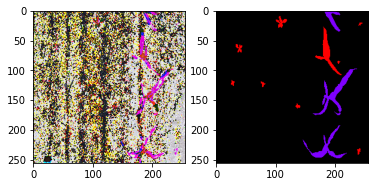

In [41]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]


fig, ax = plt.subplots(1, 2)
#len(valid_dataset)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]  # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1,3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [102]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()

for layer in vgg.layers:
  layer.trainable = True

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [103]:
def create_model(depth, start_f, num_classes,dynamic_input_shape):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    """
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2
    """
    model.add(vgg)
    
    start_f = 256
    # Bottleneck
    #model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    #model.add(tf.keras.layers.ReLU())
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [104]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=3,
                     dynamic_input_shape=False)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 256)       1179904   
_________________________________________________________________
re_lu_27 (ReLU)              (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_28 (ReLU)              (None, 32, 32, 128)      

## Prepare the model for training

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((256,256), 3)
model.summary()

In [105]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,2): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
print(len(dataset_valid))
print(len(dataset))

68
288


## Training with callbacks

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()
"""
exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
  
callbacks = []
"""
# Model checkpoint
# ----------------
"""
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)
"""
# Visualize Learning on Tensorboard
# ---------------------------------
"""
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
callbacks = []
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=2)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=10,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)
"""
# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

"\nexps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')\nif not os.path.exists(exps_dir):\n    os.makedirs(exps_dir)\n\nnow = datetime.now().strftime('%b%d_%H-%M-%S')\n\nmodel_name = 'CNN'\n\nexp_dir = os.path.join(exps_dir, model_name + '_' + str(now))\nif not os.path.exists(exp_dir):\n    os.makedirs(exp_dir)\n  \ncallbacks = []\n"

"\nckpt_dir = os.path.join(exp_dir, 'ckpts')\nif not os.path.exists(ckpt_dir):\n    os.makedirs(ckpt_dir)\n\nckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), \n                                                   save_weights_only=True)  # False to save the model directly\ncallbacks.append(ckpt_callback)\n"

"\ntb_dir = os.path.join(exp_dir, 'tb_logs')\nif not os.path.exists(tb_dir):\n    os.makedirs(tb_dir)\n    \n# By default shows losses and metrics for both training and validation\ntb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,\n                                             profile_batch=0,\n                                             histogram_freq=0)  # if 1 shows weights histograms\ncallbacks.append(tb_callback)\n"

Epoch 1/10
  2/288 [..............................] - ETA: 2:51:12 - loss: 2.0129 - accuracy: 0.0263 - meanIoU: 0.0136

In [107]:
callbacks = []
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=5,  #### set repeat in training dataset
          steps_per_epoch=30,
          validation_data=valid_dataset,
          validation_steps=5, 
          callbacks=callbacks)

Epoch 1/5
30/30 [==============================] - 167s 6s/step - loss: 1.0945 - accuracy: 0.9308 - meanIoU: 8.7628e-04 - val_loss: 0.8733 - val_accuracy: 0.9458 - val_meanIoU: 3.1149e-12
Epoch 2/5
30/30 [==============================] - 170s 6s/step - loss: 1.3137 - accuracy: 0.9185 - meanIoU: 2.2795e-12 - val_loss: 0.8733 - val_accuracy: 0.9458 - val_meanIoU: 3.1149e-12
Epoch 3/5
30/30 [==============================] - 127s 4s/step - loss: 1.3286 - accuracy: 0.9176 - meanIoU: 2.3311e-12 - val_loss: 0.8733 - val_accuracy: 0.9458 - val_meanIoU: 3.1149e-12


## Test model

## Compute prediction

In [ ]:
#model.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Nov27_08-41-36/ckpts/cp_02.ckpt')
weights = model.get_weights()
weights

In [108]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 256, 256, 3)

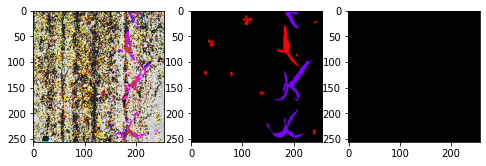

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()

image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))
#out_sigmoid

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
#predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])


target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

In [101]:
from PIL import Image

class CustomDataSol(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, img_generator=None,
               preprocessing_function=None, out_shape=[256, 256],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    subset_filenames = []
    subset_direc = []
    name_project = []
    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images')) # dir is your directory path
        number_files = len(list)
        for ii in range(0,number_files):
            subset_filenames.append(os.path.splitext(list[ii])[0])
            subset_direc.append(path)
            name_project.append(project)


    self.dataset_dir = dataset_dir
    self.projects = name_project
    self.subset_direc = subset_direc
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))

    # Resize image 
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr

################################################################################
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


################################################################################


test_set=CustomDataSol('/content/drive/My Drive/Keras_Tutorial_4/Development_Dataset/Test_Dev/', 
                        img_generator=img_data_gen,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais'])
test_dataset = tf.data.Dataset.from_generator(lambda: test_set,
                                               output_types= tf.float32,
                                               output_shapes=[img_h, img_w, 3])

test_dataset = test_dataset.batch(1)
iterator = iter(test_dataset)
test_set.__len__()
    
    submission_dict = {}
    for index in range(0,test_set.__len__()):
      image = next(iterator)
      img_name = os.path.splitext(test_set.subset_filenames[index])[0]
      submission_dict[img_name] = {}
      

    # load mask <- HERE you should have your segmentation model instead
      mask_arr =  model.predict(image)
      predicted_class = tf.argmax(mask_arr, -1)
      predicted_class = predicted_class[0, ...]
      
      prediction_img = np.zeros([target.shape[0], target.shape[1], 3])
      prediction_img[np.where(predicted_class == 0)] = 0
      for i in range(1, 3):
        prediction_img[np.where(predicted_class == i)] = i

      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = test_set.projects[index]
      submission_dict[img_name]['crop'] = 'Mais'
      submission_dict[img_name]['segmentation'] = {}

    
    

    # RLE encoding
    # crop
      rle_encoded_crop = rle_encode(prediction_img == 1)
    # weed
      rle_encoded_weed = rle_encode(prediction_img == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

    # Please notice that in this example we have a single prediction.
    # For the competition you have to provide segmentation for each of
    # the test images.

    # Finally, save the results into the submission.json file
    import json
    with open('/content/drive/My Drive/submission.json', 'w') as file:
        json.dump(submission_dict, file)

60